In [40]:
import pandas as pd                               # panda
import pandas_datareader as pdr                   # Baixar dados yahoo

import matplotlib.pyplot as plt                   # grafico
import matplotlib.dates as mdates                 # trabalhar datas

import statsmodels.api as sm                      # regressao
from statsmodels.api import add_constant          # para a regressao considerar o intercepto

import numpy as np
import scipy.stats

from statsmodels.tsa.stattools import coint       # Funcao Coint ()
from statsmodels.tsa.stattools import adfuller

# Declaracoes
pd.options.display.float_format = '{:.2f}'.format


### DECLARACAO DE FUNCOES ###

In [302]:
# Baixa base de dados e retorna uma base da forma [data,close_ativo_1, close_ativo_2]
def baixar_yahoo(tickers,inicio,fim,baixayahoo):

    # Percorre a lista tickers, lendo o yahoo e salvando no DataFrame db
    db = pd.DataFrame()
    if (baixayahoo == True):
        
        for i in tickers:
            cot = pdr.DataReader(i, 'yahoo', inicio,fim)
            cot['Ativo']=i
            db = pd.concat([db,cot],sort=True)  

        db.to_csv('Ativos.csv')
        #db.to_excel('Ativos.xlsx')
    
    db = pd.read_csv('Ativos.csv',parse_dates=[0], infer_datetime_format = True)
    #db = pd.read_excel('ENATBRAP.xls')
    db = db[['Ativo','Date','Open','High','Low','Adj Close']].rename(columns={'Adj Close': 'Close'})    

    # Cria Tabela com os fechamentos dos dois ativos [DATA, Close1, Close2]
    esquerda = db[db['Ativo']==tickers[0]].set_index('Date')['Close']
    direita = db[db['Ativo']==tickers[1]].set_index('Date')['Close']
    par = pd.merge(left=esquerda, right=direita, left_on='Date', right_on='Date').rename(columns={'Close_x': tickers[0], 'Close_y': tickers[1]})

    #par.to_excel('Par.xlsx')
    
    return par



In [591]:
def regressao(par_subset, tickers):
    
    # Gera a REGRESSAO LINEAR MULTIVARIADA (QuantGo "Simples") -> y = b*x + c*t + d + e
    X = np.column_stack((par_subset[tickers[1]], range(1,i+1,1)))
    X = sm.add_constant(X, prepend=True)
    res = sm.OLS(par_subset[tickers[0]],X).fit()

    coef_ang=res.params[1]
    residuo = pd.DataFrame()
    residuo = par_subset[tickers[0]]-res.predict()
    zscore  = (residuo - np.mean(residuo))/np.std(residuo);
    return coef_ang, residuo, zscore 


# ADF da Statsmodel
def adftest(df):

    adf  = adfuller(df, maxlag=2, autolag=None)
 
    if adf[0]   < adf[4]['1%']:  adfc='99%'
    elif adf[0] < adf[4]['5%']:  adfc='95%'
    elif adf[0] < adf[4]['10%']: adfc='90%'
    else:                        adfc='0%'                 

    return adf[0], adfc,adf[1];      

# ADF feito na raça
def adftest_na_mao(residuos):
 
    X = sm.add_constant(residuos.diff()[1:], prepend=True)
    res = sm.OLS(residuos[1:],X).fit()

    DF = res.params[1]/res.bse[1]
    adfc="XX%" # nao fiz, apenas mantendo os parametros de retorno da funcao acima
    pvalue=99  # nao fiz, apenas mantendo os parametros de retorno da funcao acima
    
    return DF, adfc, pvalue

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    
    r, p = scipy.stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = scipy.stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    
    return r, p, lo, hi
    

In [592]:
## Funcoes graficas

def grafico_residuo(residuo):
        
    plt.figure(figsize=(20,4))
    ax = residuo.plot(color='g', grid=True, label='Z-Score')
    plt.axhline(residuo.mean(), color='red')
    plt.axhline(residuo.mean()+2*residuo.std(), color='blue')
    plt.axhline(residuo.mean()-2*residuo.std(), color='blue')

    ax.xaxis_date()  # formata o timestamp para o formato data
    ax.set_axisbelow(True)
    ax.set_title('Residuos', color='black')
    ax.set_facecolor('white')
    ax.figure.set_facecolor('white')

    plt.legend()
    plt.show()    
        

In [594]:

tickers = ['YDUQ3.SA', 'MDIA3.SA'];

# Busca cotacoes no Yahoo Finance
par = baixar_yahoo(tickers, '2019-1-1','2020-7-23',True)

# Cria o cubo de periodos
cubo = pd.DataFrame(columns=['Periodo','Dickey_Fuller','ADF','Coef_Ang','QTD_Desvios','Fisher_min','Fisher_max',
                             'ADF_pvalue','Coint', 'Coint1'])

# Popula o cubo de periodos
#for i in range(100,260,10):
for i in [100,120,140,160,180,200,220,240,250]:
 
    # Cria subset do tamanho do periodo atual da iteração
    par_subset = par.tail(i)
    
    # Adiciona o PERIODO analisado no dataframe
    cubo = cubo.append({'Periodo': int(i)}, ignore_index=True)
    
    # Gera a REGRESSAO e retorna o Coef Ang, e o z-score
    coef_ang, residuo, zscore = regressao(par_subset, tickers)

    # Teste de Estacionariedade dos Resíduos (ADF)
    adfstat,adfc,adfpvalue = adftest(residuo)
 
    # Calculo do Fisher
    ficher_r, fisher_pvalue, fisher_lo, fisher_hi = pearsonr_ci(par_subset[tickers[1]].pct_change().dropna(),
                                                                par_subset[tickers[0]].pct_change().dropna())
    
    # Calculo da Meia-vida

    
    
    # Preenchimento do cubo
    cubo.loc[cubo['Periodo']==i, 'Coef_Ang']=coef_ang 
    cubo.loc[cubo['Periodo']==i, 'QTD_Desvios']=zscore.tail(1).values
    cubo.loc[cubo['Periodo']==i, 'Dickey_Fuller']=adfstat
    cubo.loc[cubo['Periodo']==i, 'ADF']=adfc 
    cubo.loc[cubo['Periodo']==i, 'ADF_pvalue']=adfpvalue 
    cubo.loc[cubo['Periodo']==i, 'Fisher_min']=fisher_lo
    cubo.loc[cubo['Periodo']==i, 'Fisher_max']=fisher_hi

    
    
    
display(cubo)

# Desvio médio do Coef. Angular - apenas dos periodos cointegrados
cubo_cointegrado = cubo.loc[cubo['ADF'] != '0%']
print("Desvio Medio do Coef. Angular: {:.2%}" .format(cubo_cointegrado['Coef_Ang'].std()/cubo_cointegrado['Coef_Ang'].mean()))



,Periodo,Dickey_Fuller,ADF,Coef_Ang,QTD_Desvios,Fisher_min,Fisher_max,ADF_pvalue,Coint,Coint1
0,100.00,-3.38,95%,1.65,1.16,0.30,0.61,0.01,nan,nan
1,120.00,-3.83,99%,1.77,1.37,0.30,0.59,0.00,nan,nan
2,140.00,-4.06,99%,1.74,1.17,0.30,0.57,0.00,nan,nan
3,160.00,-4.20,99%,1.74,1.29,0.30,0.56,0.00,nan,nan
4,180.00,-3.92,99%,1.75,0.46,0.31,0.55,0.00,nan,nan
5,200.00,-3.21,95%,1.76,0.01,0.29,0.52,0.02,nan,nan
6,220.00,-2.86,90%,1.73,-0.34,0.30,0.52,0.05,nan,nan
7,240.00,-2.48,0%,1.60,-0.58,0.30,0.51,0.12,nan,nan
8,250.00,-2.08,0%,1.51,-0.66,0.31,0.51,0.25,nan,nan


Desvio Medio do Coef. Angular: 2.18%


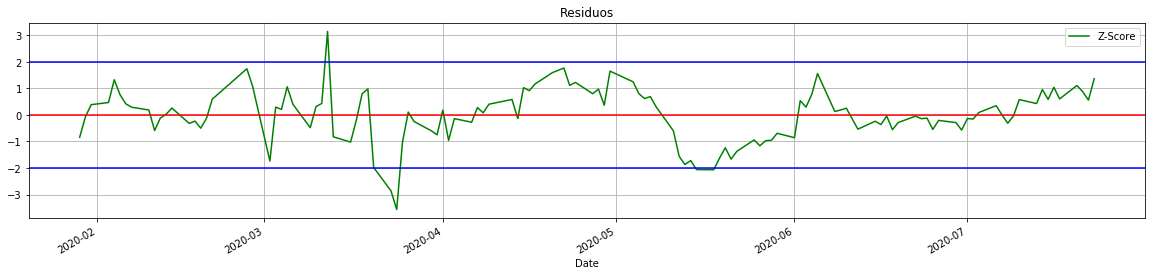

In [511]:
# Gera os graficos do Desvio para o periodo selecionado

##### Substituir pelo periodo que quer analisar  ######
periodo = 120;
##### Substituir pelo periodo que quer analisar  ######
        
X = np.column_stack((par[tickers[1]].tail(int(periodo)), range(1,int(periodo)+1,1)))
X = sm.add_constant(X, prepend=True)
res = sm.OLS(par[tickers[0]].tail(int(periodo)),X).fit()

par_subset1 = pd.DataFrame()
par_subset1['residuo'] = par[tickers[0]].tail(periodo)-res.predict()
par_subset1['zscore']  = (par_subset1['residuo'] - np.mean(par_subset1['residuo']))/np.std(par_subset1['residuo']);

grafico_residuo(par_subset1['zscore'])

